In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Genome:
    def __init__(self, mutations, genome_length):
        self.mutations = mutations
        self.genome_length = genome_length
    
    def get_fitness(self, fitness_landscape):
        if isinstance(fitness_landscape, int):
            return 1
        if len(self.mutations)==0:
            return 1
        fitnesses = []
        for position, mutation in self.mutations.items():
            fitnesses.append(fitness_landscape.loc[(position, mutation)])
        return np.product(fitnesses)
                
    def mutate(self, number_of_mutations):
        new_mutations_positions = np.random.randint(0, self.genome_length, number_of_mutations)
        for position in new_mutations_positions:
            possible_mutations = set(range(1,4))
            if position in self.mutations.keys():
                possible_mutations = set(range(4)) - {self.mutations[position]}
            mutation = np.random.choice(list(possible_mutations))
            if mutation == 0:
                del self.mutations[position]  # no need to remember a lack of a mutation
            else:
                self.mutations[position] = mutation


def create_fitness_landscape(A,B, genome_length):
    dummy_records = []
    for position in range(genome_length):
        for mutation in range(4):
            dummy_records.append({'position': position, 'mutation': mutation})
    fitness_landscape = pd.DataFrame.from_records(dummy_records)
    fitness_landscape['fitness'] = 1  # first we give everyone fitness 1
    # then everything with a mutation get a different fitness from out distribution
    fitness_landscape.loc[fitness_landscape['mutation']!=0, 'fitness'] = np.random.gamma(A,B, genome_length*3)
    return fitness_landscape.set_index(['position', 'mutation'])
        
    
def normalize(array):
    return array / np.linalg.norm(array, ord=1)


def get_next_genomes(passage_df, num_of_genomes_to_simulate, genome_length, fitness_landscape):
    # TODO: figure out how to not lose genomes in rounding
    genomes = []
    rounded_freqs = round(normalize(passage_df.groupby('muts')['fitness'].sum()), 
                          int(np.log10(num_of_genomes_to_simulate)))
    genomes_freqs = (rounded_freqs * num_of_genomes_to_simulate).astype(int)
    genomes_freqs = genomes_freqs[genomes_freqs>0]
    for mutations, number_of_genomes in genomes_freqs.iteritems():
        mutations_dict = dict()
        if mutations != "":
            for mutation_datum in mutations.split('_'):
                position, mutation = mutation_datum.split('-')
                mutations_dict[int(position)] = int(mutation)
        for i in range(number_of_genomes):
            genomes.append(Genome(mutations=mutations_dict.copy(), genome_length=genome_length))
    return genomes
    
    
def mutations_to_string(mutations):
    return '_'.join([str(position)+'-'+str(mutation) for position, mutation in sorted(mutations.items())])


def model(A, B, U, genome_length, number_of_passages, num_of_genomes_to_simulate, syns=False):
    if syns:
        fitness_landscape = 1
    else:
        fitness_landscape = create_fitness_landscape(A,B, genome_length)
    genomes = []
    passage_dfs = []
    for i in range(num_of_genomes_to_simulate):
        genomes.append(Genome(mutations=dict(), genome_length=genome_length))
    for p in range(1, number_of_passages+1):
        passage_data = []
        for j in range(len(genomes)):
            number_of_new_mutations = np.random.poisson(U)
            genomes[j].mutate(number_of_new_mutations)
            passage_data.append({'mutations': genomes[j].mutations, 
                                 'fitness': genomes[j].get_fitness(fitness_landscape), 
                                 'passage': p})
        passage_df = pd.DataFrame.from_records(passage_data)
        passage_df['muts'] = passage_df['mutations'].map(mutations_to_string)
        passage_dfs.append(passage_df)
        genomes = get_next_genomes(passage_df, num_of_genomes_to_simulate, genome_length, fitness_landscape)
    data = pd.concat(passage_dfs)
    data['mut_num'] = data['muts'].str.count('_') + 1
    data.loc[data['muts']=='', 'mut_num'] = 0
    freqs = data.groupby('passage').muts.value_counts(normalize=True)
    freqs.name = 'freq'
    freqs = freqs.reset_index().merge(data, how='left', on=['muts','passage'])
    freqs = freqs.drop_duplicates(['mut_num', 'passage', 'freq'])
    return data, freqs.reset_index(drop=True)

## These will be our parameters to play with:

In [3]:
A = 2
B = 0.2
U = 0.2
genome_length = 3560
number_of_passages = 10
num_of_genomes_to_simulate = 1000 # more genomes means less drift and longer calculation

<AxesSubplot:ylabel='Count'>

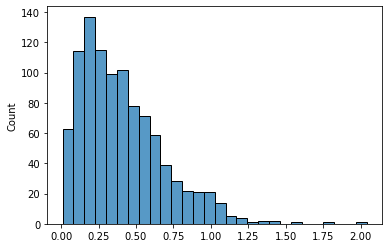

In [4]:
sns.histplot(np.random.gamma(A,B, 1000))  # this is our example fitness landscape

In [5]:
# running with all fitness = 1
syns, syns_freqs = model(A, B, U, genome_length, number_of_passages, num_of_genomes_to_simulate, syns=True)

In [6]:
# running with the fitness landscape as given by A,B above
genomes, freqs = model(A, B, U, genome_length, number_of_passages, num_of_genomes_to_simulate, syns=False)

Text(0.5, 1.0, 'Just Syns')

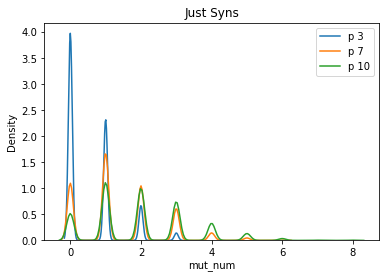

In [7]:
sns.kdeplot(syns[syns.passage==3].mut_num, bw_adjust=0.3, label='p 3')
sns.kdeplot(syns[syns.passage==7].mut_num, bw_adjust=0.3, label='p 7')
sns.kdeplot(syns[syns.passage==10].mut_num, bw_adjust=0.3, label='p 10')
plt.legend()
plt.title("Just Syns")

Text(0.5, 1.0, 'With Fitness Landscape')

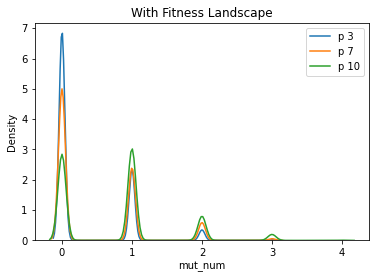

In [8]:
sns.kdeplot(genomes[genomes.passage==3].mut_num, bw_adjust=0.3, label='p 3')
sns.kdeplot(genomes[genomes.passage==7].mut_num, bw_adjust=0.3, label='p 7')
sns.kdeplot(genomes[genomes.passage==10].mut_num, bw_adjust=0.3, label='p 10')
plt.legend()
plt.title("With Fitness Landscape")

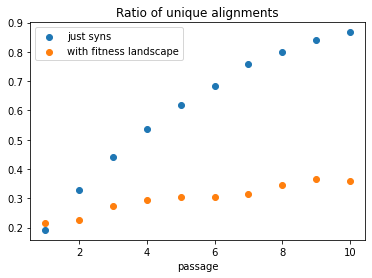

In [9]:
syns_ratios = syns.groupby('passage').muts.nunique() / syns.groupby('passage').muts.count() 
asd = genomes.groupby('passage').muts.nunique() / genomes.groupby('passage').muts.count() 
plt.scatter(syns_ratios.index, syns_ratios, label='just syns')
plt.scatter(asd.index, asd, label='with fitness landscape')
plt.title('Ratio of unique alignments')
plt.xlabel('passage')
plt.legend()

Text(0, 0.5, 'frequency')

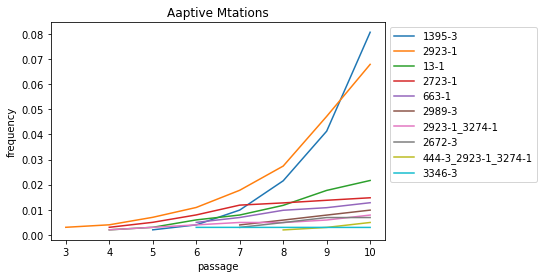

In [10]:
frequent_muts = freqs[(freqs.passage==10) & (freqs.muts!="")].sort_values('freq', ascending=False).head(10)['muts']
for mutation in frequent_muts:
    tmp = freqs[freqs.muts==mutation]
    plt.plot(tmp.passage, tmp.freq, label=mutation)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Aaptive Mtations')
plt.xlabel('passage')
plt.ylabel('frequency')

In [13]:
freqs[freqs.passage==10].sort_values('freq', ascending=False)

,passage,muts,freq,mutations,fitness,mut_num
91,10,,0.413386,{},1.000000,0
92,10,1395-3,0.080709,{1395: 3},2.165423,1
93,10,2923-1,0.067913,{2923: 1},1.741921,1
94,10,13-1,0.021654,{13: 1},1.609124,1
95,10,2723-1,0.014764,{2723: 1},1.318278,1
96,10,663-1,0.012795,{663: 1},1.338242,1
97,10,2989-3,0.009843,{2989: 3},1.514235,1
98,10,2923-1_3274-1,0.007874,"{2923: 1, 3274: 1}",1.368995,2
99,10,2672-3,0.006890,{2672: 3},1.494696,1
100,10,444-3_2923-1_3274-1,0.004921,"{444: 3, 2923: 1, 3274: 1}",1.484800,3
